True
Vessels: [[], [], [], [], [], [], [], [(128, 281), (127, 279), (130, 288), (131, 291), (142, 291)], [], [], [], [], [[113, 245], (117, 255), [119, 258], (126, 241), (128, 245), (129, 252), (129, 249)], [], [(255, 119), (259, 118)], [], [], [], [(363, 326), (363, 330)], [(163, 525), (180, 523)], [], [], [], [[204, 453], (216, 448)], [], [], [], [], [(389, 332), (394, 340)], [], [], [(278, 125), (281, 136), (283, 136), (286, 135), (289, 135)], [], [(252, 85), (255, 93)], [], [], [], [], [], [], [], [], [], [(237, 552)], [], [], [], [], [], [], [(274, 118), (279, 126)], []]
 
List is empty
List is empty
List is empty
List is empty
List is empty
List is empty
List is empty
[(128, 281), (127, 279), (130, 288), (131, 291), (142, 291)]
List is empty
List is empty
List is empty
List is empty
[[113, 245], (117, 255), [119, 258], (126, 241), (128, 245), (129, 252), (129, 249)]
List is empty
[(255, 119), (259, 118)]
List is empty
List is empty
List is empty
[(363, 326), (363, 330)]
[(163, 52

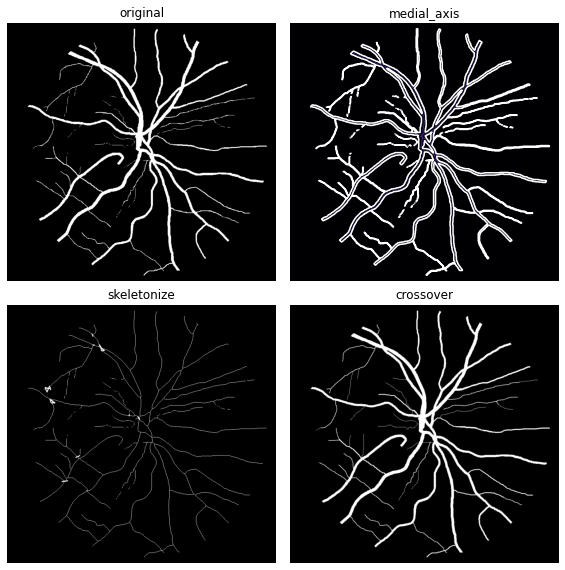

In [46]:
%matplotlib inline


import cv2
import numpy as np
from skimage import color, feature, filters, io
from skimage.morphology import skeletonize,medial_axis
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as nd
np.set_printoptions(threshold=sys.maxsize)


def image_resize(image, width = 800, height = 600, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized
def neighbours(x,y,image):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1;
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]   

def vessel_width(thresholded_image: np.ndarray, landmarks: list):
    image = thresholded_image.copy()
    widths = []
    for j in landmarks:
        w0 = w45 = w90 = w135 = 0
        w180 = w225 = w270 = w315 = 1
        while True:
            if image[j[0], j[1] + w0 + 1] != 0:
                w0 += 1
            if image[j[0], j[1] - w180 - 1] != 0:
                w180 += 1
            if image[j[0] - w45 - 1, j[1] + w45 + 1] != 0:
                w45 += 1
            if image[j[0] + w225 + 1, j[1] - w225 - 1] != 0:
                w225 += 1
            if image[j[0] - w90 - 1, j[1]] != 0:
                w90 += 1
            if image[j[0] + w270 + 1, j[1]] != 0:
                w270 += 1
            if image[j[0] - w135 - 1, j[1] - w135 - 1] != 0:
                w135 += 1
            if image[j[0] + w315 + 1, j[1] + w315 + 1] != 0:
                w315 += 1

            if image[j[0], j[1] + w0 + 1] == 0 and image[j[0], j[1] - w180 - 1] == 0:
                widths.append([0, w0, w180])
                break
            elif image[j[0] - w45 - 1, j[1] + w45 + 1] == 0 and image[j[0] + w225 + 1, j[1] - w225 - 1] == 0:
                widths.append([45, w45, w225])
                break
            elif image[j[0] - w90 - 1, j[1]] == 0 and image[j[0] + w270 + 1, j[1]] == 0:
                widths.append([90, w90, w270])
                break
            elif image[j[0] - w135 - 1, j[1] - w135 - 1] == 0 and image[j[0] + w315 + 1, j[1] + w315 + 1] == 0:
                widths.append([135, w135, w315])
                break

    return widths


def getEndPoints(skeleton):
    '''
    Find the endpoints of the skeleton.
    '''

    end_points = list()
    end_structs = [np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 0]]),
               np.array([[0, 1, 0],
                         [0, 1, 0],
                         [0, 0, 0]]),
               np.array([[0, 0, 1],
                         [0, 1, 0],
                         [0, 0, 0]]),
               np.array([[0, 0, 0],
                         [1, 1, 0],
                         [0, 0, 0]]),
               np.array([[0, 0, 0],
                         [0, 1, 1],
                         [0, 0, 0]]),
               np.array([[0, 0, 0],
                         [0, 1, 0],
                         [1, 0, 0]]),
               np.array([[0, 0, 0],
                         [0, 1, 0],
                         [0, 1, 0]]),
               np.array([[0, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]])]

    for i, struct in enumerate(end_structs):
        hits = nd.binary_hit_or_miss(skeleton, structure1=struct)

        if not np.any(hits):
            continue

        for y, x in zip(*np.where(hits)):
            end_points.append((x, y))
        # Filter intersections to make sure we don't count them twice or ones that are very close together
    for point1 in end_points:
        for point2 in end_points:
            if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
                end_points.remove(point2);
    # Remove duplicates
    end_points = list(set(end_points));        

    return end_points

def getIntersections(skeleton):
   
    intersections_structs = [np.array([
                         [1, 0, 1],
                         [0, 1, 0],
                         [0, 1, 0]]),
               np.array([[0, 1, 0],
                         [0, 1, 1],
                         [1, 0, 0]]),
               np.array([[0, 0, 1],
                         [1, 1, 0],
                         [0, 0, 1]]),
               np.array([[1, 0, 0],
                         [0, 1, 1],
                         [0, 1, 0]]),
               np.array([[0, 1, 0],
                         [0, 1, 0],
                         [1, 0, 1]]),
               np.array([[0, 0, 1],
                         [1, 1, 0],
                         [0, 1, 0]]),
               np.array([[1, 0, 0],
                         [0, 1, 1],
                         [1, 0, 0]]),
               np.array([[0, 1, 0],
                         [1, 1, 0],
                         [0, 0, 1]]),
               np.array([[1, 0, 0],
                         [0, 1, 0],
                         [1, 0, 1]]),                             
               np.array([[1, 0, 1],
                         [0, 1, 0],
                         [1, 0, 0]]),
               np.array([[1, 0, 1],
                         [0, 1, 0],
                         [0, 0, 1]]),                             
               np.array([[0, 0, 1],
                         [0, 1, 0],
                         [1, 0, 1]]),                            
               np.array([[0, 1, 0],
                         [1, 1, 0],
                         [0, 1, 0]]),
               np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 0, 0]]),                             
               np.array([[0, 1, 0],
                         [0, 1, 1],
                         [0, 1, 0]]),                            
               np.array([[0, 0, 0],
                         [1, 1, 1],
                         [0, 1, 0]]),                            
               np.array([[0, 0, 1],
                         [1, 1, 1],
                         [0, 0, 1]]),                             
               np.array([[0, 1, 0],
                         [0, 1, 0],
                         [1, 1, 1]]),                            
               np.array([[1, 0, 0],
                         [1, 1, 1],
                         [1, 0, 0]]),                            
               np.array([[1, 1, 1],
                         [0, 1, 0],
                         [0, 1, 0]]),                             
               np.array([[0, 1, 1],
                         [1, 1, 0],
                         [0, 1, 0]]),                            
               np.array([[0, 1, 0],
                         [1, 1, 0],
                         [0, 1, 1]]),                            
               np.array([[0, 1, 1],
                         [1, 1, 0],
                         [0, 1, 1]]),                             
               np.array([[1, 1, 0],
                         [0, 1, 1],
                         [1, 1, 0]]),                            
               np.array([[1, 0, 1],
                         [1, 1, 1],
                         [0, 1, 0]]),    
               np.array([[1, 0, 0],
                         [1, 1, 1],
                         [0, 1, 0]]),                             
               np.array([[1, 1, 0],
                         [0, 1, 1],
                         [0, 1, 0]]),                            
               np.array([[0, 1, 0],
                         [0, 1, 1],
                         [1, 1, 0]]),                             
               np.array([[0, 0, 1],
                         [1, 1, 1],
                         [0, 1, 0]]),                             
               np.array([[0, 1, 0],
                         [1, 1, 1],
                         [1, 0, 1]]),                            
               np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 0, 1]]),
               np.array([[0, 1, 0],
                         [1, 1, 1],
                         [1, 0, 0]]),                             
               np.array([[1, 0, 0],
                         [0, 1, 1],
                         [1, 1, 0]]),                            
               np.array([[1, 1, 0],
                         [0, 1, 1],
                         [1, 0, 0]]),                            
               np.array([[1, 0, 1],
                         [1, 1, 0],
                         [0, 1, 0]]),                             
               np.array([[1, 0, 1],
                         [0, 1, 1],
                         [0, 1, 0]]),                            
               np.array([[0, 1, 0],
                         [0, 1, 1],
                         [1, 0, 1]]),                            
               np.array([[0, 1, 0],
                         [1, 1, 0],
                         [1, 0, 1]]),                             
               np.array([[0, 0, 1],
                         [1, 1, 0],
                         [0, 1, 1]]),                            
               np.array([[0, 1, 1],
                         [1, 1, 0],
                         [0, 0, 1]]),
                            ]                         
                         
                            
                            
    image = skeleton.copy();
    image = image/255;
    intersections = list()

    for i, struct in enumerate(intersections_structs):
        hits = nd.binary_hit_or_miss(image, structure1=struct)

        if not np.any(hits):
            continue

        for y, x in zip(*np.where(hits)):
            intersections.append((x, y))
      # Filter intersections to make sure we don't count them twice or ones that are very close together
    for point1 in intersections:
        for point2 in intersections:
            if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
                intersections.remove(point2);
    # Remove duplicates
    intersections = list(set(intersections));
    return intersections
    

def getSkeletonIntersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.

    Keyword arguments:
    skeleton -- the skeletonised image to detect the intersections of

    Returns: 
    List of 2-tuples (x,y) containing the intersection coordinates
    """
    # A biiiiiig list of valid intersections             2 3 4
    # These are in the format shown to the right         1 C 5
    #                                                    8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]
                       
                        ];
    image = skeleton.copy();
    image = image/255;
    intersections = list();
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # If we have a white pixel
            if image[x][y] == 1:
                nb = neighbours(x,y,image);
                valid = True;
                if nb in validIntersection:
                    intersections.append((y,x));
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    for point1 in intersections:
        for point2 in intersections:
            if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
                intersections.remove(point2);
    # Remove duplicates
    intersections = list(set(intersections));
    return intersections;

def finding_landmark_vessels(widths: list, landmarks: list, skeleton: np.ndarray, skeleton_rgb: np.ndarray):
    vessels = []
    for l in range(0, len(widths)):
        cgray = skeleton.copy()
        crgb = skeleton_rgb.copy()
        radius = int(np.ceil(widths[l][1] + widths[l][2] * 1.5))
        x0 = landmarks[l][0]
        y0 = landmarks[l][1]
        points = []
        dy = x = y = 0
        crgb[x0, y0] = [0, 255, 0]
        for start in range(0, 2):
            for rad in range(-radius, radius + 1):
                dy = int(np.round(np.sqrt(np.power(radius, 2) - np.power(rad, 2))))
                for loop in range(0, 2):
                    if start == 0:
                        x = x0 + rad
                        if loop == 0:
                            y = y0 - dy
                        else:
                            y = y0 + dy
                    else:
                        y = y0 + rad
                        if loop == 0:
                            x = x0 - dy
                        else:
                            x = x0 + dy

                    acum = 0
                    for i in range(-2, 3):
                        for j in range(-2, 3):
                            if all(crgb[x + i, y + j] == [0, 0, 255]):
                                acum += 1

                    if cgray[x, y] == 255 and acum == 0:
                        crgb[x, y] = [0, 0, 255]
                        cgray[x - 1:x + 2, y - 1:y + 2] = 0
                        cgray[x, y] = 255
                        points.append([x, y])
                    elif acum == 0:
                        crgb[x, y] = [255, 0, 0]
                        block = cgray[x - 1:x + 2, y - 1:y + 2]
                        connected_components = cv2.connectedComponentsWithStats(block.astype(np.uint8), 8, cv2.CV_8U)
                        for k in range(1, connected_components[0]):
                            mask = connected_components[1] == k
                            indexes = np.column_stack(np.where(mask))
                            for e in range(0, len(indexes)):
                                ix = x + indexes[e][0] - 1
                                iy = y + indexes[e][1] - 1
                                if e == int(len(indexes) / 2):
                                    crgb[ix, iy] = [0, 0, 255]
                                    points.append((ix, iy))

        vessels.append(points)
    return vessels
# def skeletonizeHM(img):
#     h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]])
#     m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
#     h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]])
#     m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])
#     hit_list = []
#     miss_list = []
#     for k in range(4):
#         hit_list.append(np.rot90(h1, k))
#         hit_list.append(np.rot90(h2, k))
#         miss_list.append(np.rot90(m1, k))
#         miss_list.append(np.rot90(m2, k))
#     img = img.copy()
#     while True:
#         last = img
#         for hit, miss in zip(hit_list, miss_list):
#             hm = m.binary_hit_or_miss(img, hit, miss)
#             img = np.logical_and(img, np.logical_not(hm))
#         if np.all(img == last):
#             break
#     return img
# def getSkeletonIntersectionHitOrMiss(skeleton):
#     # Construct the structuring element
#     kernel = np.array((
#         [1, 1, 1],
#         [0, 1, -1],
#         [0, 1, -1]), dtype="int")
#     image = skeleton.copy()
#     image = image/255
#     intersections = list()
#     output_image = cv.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel)
    
def two_point_dist(pt1, pt2):
    return np.linalg.norm([x2 - x1 for x2, x1 in zip(pt1, pt2)])    
def avg_pts(pts):
    dims = len(pts[0])
    avg_pt = []
    for dim in range(dims):
        avg_pt.append(np.mean([pt[dim] for pt in pts]).astype(int))
    return avg_pt

def bin_to_bgr(image):
        """Transform the image to a ndarray with depth:3"""
        img = image.copy()
        h, w = img.shape
        image_bgr = np.zeros((h, w, 3))
        image_bgr[:, :, 0] = img
        image_bgr[:, :, 1] = img
        image_bgr[:, :, 2] = img
        imge= image_bgr
        return img
    
def bin_to_bgr_(bin_image):
    rgb_img = cv2.cvtColor(bin_image, cv2.COLOR_GRAY2RGB)
    return rgb_img

def get_uint_image(image):
    """
    Returns the np_image converted to uint8 and multiplied by 255 to simulate grayscale
    :return: a ndarray image
    """
    #image = np.uint8(image) *255
    img = image.astype(np.uint8) * 255
    return img


img = cv2.imread('sample/vessel1.png')

if img is None:
    print('Error loading image')
    exit()
resized = image_resize(img)    
frame = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
#ret, bw_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret, frame = cv2.threshold(frame, 127, 1, cv2.THRESH_BINARY)
#ret,frame = cv2.threshold(img,127,255,0)
#binary = frame > filters.threshold_otsu(frame)
#np.unique(binary)

skel, distance = medial_axis(frame, return_distance=True)

skeleton = skeletonize(frame)
# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel


print(np.any(skeleton[:, :] == 1 ))
colour_frame = img

rows = frame.shape[0]
cols = frame.shape[1]
skeleton = get_uint_image(skeleton)
skeleton_rgb = bin_to_bgr_(skeleton)
#branch_locations = getSkeletonIntersection(skeleton)
branch_locations = getIntersections(skeleton)
end_points = getEndPoints(skeleton)

all_points = branch_locations + end_points

v_width = vessel_width(frame,branch_locations)
vessels = finding_landmark_vessels(v_width, branch_locations, skeleton, skeleton_rgb)
print ("Vessels:",vessels)
print(" ")
#print(v_width)
for points in vessels:
    
    if not points:
          print("List is empty")
          continue 
    print(points)
    cv2.drawContours(skeleton, np.array([points]), 0, (255,0,0), 2)
#     cv2.circle(skeleton,tuple(point) , 2, (255, ++1, 0), 5)
#         cv2.circle(img,point , 2, (255, 0, 0), 5)
    
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(frame, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(frame, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')    

ax[3].imshow(resized, cmap=plt.cm.gray)
ax[3].set_title('crossover')
ax[3].axis('off')    


fig.tight_layout()
plt.show()
cv2.imshow("Frame", skeleton)
#cv2.imshow("Frame1", img)

cv2.waitKey(0)
cv2.destroyAllWindows()